# How to use Deep ensembles in BaaL

Ensemble are one of the easiest form of Bayesian deep learning.
 The main drawback from this approach is the important amount of computational resources needed to perform it.
  In this notebook, we will present BaaL's Ensemble API namely `EnsembleModelWrapper`.


This notebook is similar to our notebook on how to do research, we suggest you look at it first if you haven't.

#### Additional resources

* More info on the inner working of Active Learning Dataset [here](./fundamentals/active-learning.ipynb).
* To know more about Bayesian deep learning please see our Literature review.

In [1]:
import random
from copy import deepcopy
from dataclasses import dataclass

import numpy as np
import torch.backends
from torch import optim, nn
from torch.hub import load_state_dict_from_url
from torch.nn import CrossEntropyLoss
from torchvision import datasets
from torchvision import models
from torchvision.transforms import transforms
from tqdm.autonotebook import tqdm

from baal.active import get_heuristic, ActiveLearningDataset
from baal.active.active_loop import ActiveLearningLoop
from baal.ensemble import EnsembleModelWrapper

def vgg16(num_classes):
    model = models.vgg16(pretrained=False, num_classes=num_classes)
    weights = load_state_dict_from_url('https://download.pytorch.org/models/vgg16-397923af.pth')
    weights = {k: v for k, v in weights.items() if 'classifier.6' not in k}
    model.load_state_dict(weights, strict=False)
    return model

def weights_reset(m):
    if isinstance(m, nn.Linear):
        nn.init.normal_(m.weight, 0, 0.01)
        nn.init.constant_(m.bias, 0)

In [2]:
@dataclass
class ExperimentConfig:
    epoch: int = 15000//256
    batch_size: int = 32
    initial_pool: int = 512
    query_size: int = 100
    lr: float = 0.001
    heuristic: str = 'bald'
    iterations: int = 5 # Set a low number here since each iteration will train a new model.
    training_duration: int = 10
        

def get_datasets(initial_pool):
    transform = transforms.Compose(
        [transforms.Resize((32, 32)),
         transforms.RandomHorizontalFlip(),
         transforms.RandomRotation(30),
         transforms.ToTensor(),
         transforms.Normalize(3 * [0.5], 3 * [0.5]), ])
    test_transform = transforms.Compose(
        [
            transforms.Resize((32, 32)),
            transforms.ToTensor(),
            transforms.Normalize(3 * [0.5], 3 * [0.5]),
        ]
    )
    train_ds = datasets.CIFAR10('.', train=True,
                                transform=transform, target_transform=None, download=True)
    
    # In a real application, you will want a validation set here.
    test_set = datasets.CIFAR10('.', train=False,
                                transform=test_transform, target_transform=None, download=True)
    
    # Here we set `pool_specifics`, where we set the transform attribute for the pool.
    active_set = ActiveLearningDataset(train_ds, pool_specifics={'transform': test_transform})

    # We start labeling randomly.
    active_set.label_randomly(initial_pool)
    return active_set, test_set

In [3]:
hyperparams = ExperimentConfig()
use_cuda = torch.cuda.is_available()
torch.backends.cudnn.benchmark = True
random.seed(1337)
torch.manual_seed(1337)
if not use_cuda:
    print("warning, the experiments would take ages to run on cpu")

# Get datasets
active_set, test_set = get_datasets(hyperparams.initial_pool)

heuristic = get_heuristic(hyperparams.heuristic)
criterion = CrossEntropyLoss()
model = vgg16(num_classes=10)

if use_cuda:
    model.cuda()
optimizer = optim.SGD(model.parameters(), lr=hyperparams.lr, momentum=0.9)

# Wraps the model into a usable API.
model = EnsembleModelWrapper(model, criterion)

# for prediction we use a smaller batchsize
# since it is slower
active_loop = ActiveLearningLoop(active_set,
                                 model.predict_on_dataset,
                                 heuristic,
                                 hyperparams.query_size,
                                 batch_size=1,
                                 iterations=hyperparams.iterations,
                                 use_cuda=use_cuda,
                                 verbose=False)

# We will reset the weights at each active learning step.
init_weights = deepcopy(model.state_dict())

Files already downloaded and verified
Files already downloaded and verified


## Presenting EnsembleModelWrapper

EnsembleModelWrapper is similar to ModelWrapper, but instead of training a single model, we will train multiple.
Each model will start its training from a different set parameters.

EnsembleModelWrappe methods:

```python
class EnsembleModelWrapper:
    def add_checkpoint(self):
        """
        Add a checkpoint to the list of weights used for inference.
        """

    def clear_checkpoints(self):
        """
        Clear the list of saved checkpoints.
        """
```

As you see in the next cell, we call both of these methods alternatively.
We train N models, calling `add_checkpoint`, perform the active learning step and then restart by calling `clear_checkpoints`.


In [4]:
report = []
for epoch in tqdm(range(hyperparams.epoch)):
    model.clear_checkpoints()
    # Load the initial weights.
    for model_iter in range(hyperparams.iterations):
        print(f"Training model {model_iter}")
        model.load_state_dict(init_weights)
        model.model.apply(weights_reset)
        _ = model.train_on_dataset(active_set, optimizer=optimizer, batch_size=hyperparams.batch_size,
                                 use_cuda=use_cuda, epoch=hyperparams.training_duration)
        model.add_checkpoint()
    
    

    # Get test NLL!
    model.test_on_dataset(test_set, hyperparams.batch_size, use_cuda,
                          average_predictions=hyperparams.iterations)
    metrics = model.metrics

    # We can now label the most uncertain samples according to our heuristic.
    should_continue = active_loop.step()
    # Keep track of progress
    labelling_progress = active_set.labelled_map.astype(np.uint16)
    if not should_continue:
            break

    test_loss = metrics['test_loss'].value
    logs = {
        "test_nll": test_loss,
        "epoch": epoch,
        "Next Training set size": len(active_set)
    }
    report.append(logs)

  0%|          | 0/58 [00:00<?, ?it/s]

Training model 0
[14095-MainThread] [baal.modelwrapper:train_on_dataset:109] 2021-07-28T15:03:23.225157Z [info     ] Starting training              dataset=512 epoch=10


/opt/conda/lib/python3.9/site-packages/torch/utils/data/dataloader.py:478: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 1, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/opt/conda/lib/python3.9/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


[14095-MainThread] [baal.modelwrapper:train_on_dataset:119] 2021-07-28T15:03:54.272799Z [info     ] Training complete              train_loss=0.8364141583442688
Training model 1
[14095-MainThread] [baal.modelwrapper:train_on_dataset:109] 2021-07-28T15:03:54.281157Z [info     ] Starting training              dataset=512 epoch=10
[14095-MainThread] [baal.modelwrapper:train_on_dataset:119] 2021-07-28T15:04:27.085055Z [info     ] Training complete              train_loss=0.8260515332221985
Training model 2
[14095-MainThread] [baal.modelwrapper:train_on_dataset:109] 2021-07-28T15:04:27.092947Z [info     ] Starting training              dataset=512 epoch=10
[14095-MainThread] [baal.modelwrapper:train_on_dataset:119] 2021-07-28T15:05:00.277956Z [info     ] Training complete              train_loss=0.8478720188140869
Training model 3
[14095-MainThread] [baal.modelwrapper:train_on_dataset:109] 2021-07-28T15:05:00.286100Z [info     ] Starting training              dataset=512 epoch=10
[14095-Mai

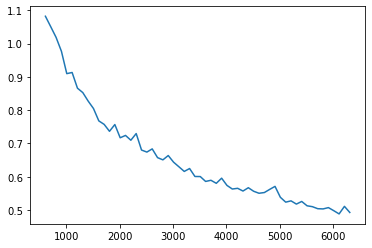

In [5]:
import matplotlib.pyplot as plt

x = [v['test_nll'] for v in report]
y = [v['Next Training set size'] for v in report]
plt.plot(y, x)